### aim: scratchpad for trying to calculate nutrient limitation from model

    


In [26]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [27]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [28]:
import numpy as np
# from cmocean import cm
# import cartopy as cp
# import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
# import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
# import pickle
import pandas as pd
# import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

## planktom equations and code notes

the constants get read in here: 
    [mep22dku@login01 /gpfs/home/avd22gnu/scratch/modelTest/RIV12/NEMO/TOP_SRC/PlankTOM]$ vim trcnam_planktom.F90

look at ocean.output to check values

we are translating 
`/gpfs/home/avd22gnu/scratch/modelTest/RIV12/NEMO/TOP_SRC/PlankTOM/bgcpro.F90`

![Example Image](nutlim-eq.png)
![Example Image](nutferlim-eq.png)

## code structure

    - read in ptrc file and get out nutrients
    - get savenam
    - read in pars for pft of choice
    - do a loop of getting limiting nutrient
    - save
    

## fxn for reading parameters from namelist

In [29]:
def find_in_namtrc(filename, variable, lon = 6, verbose = True):

    w5 = np.nan
    with open(filename, 'r') as file:
        for line in file:
            ## find and parse the variables
            if variable in line:
                w = line.strip()
                w1 = ''.join(w.split())
                w2 = w1.split('=')
                w3 = w2[1].split(',')
                w4 = w3[0:lon]
                w5 = np.array(w4).astype(float)
                if verbose: 
                    print(w)
                    print(w5)
    return w5
                        

def get_out_pars(filename):

    variable = 'rn_kmpphy'
    rn_kmpphy = find_in_namtrc(namtrc, variable)
    variable = 'rn_nutthe'
    rn_nutthe = find_in_namtrc(namtrc, variable, lon = 1)

    return rn_kmpphy, rn_nutthe



## helper routines

In [30]:
def read_in_stofoo(depth, pPFT, tval = 'p0.50'):
    
    '''
    the stofoo lookup tables are calculated in tree/LimitsOfPhytoplankton/restart_stofoo.ipynb, 
    based on year 1990 of R4B1
    '''
    rows = ['DIA', 'MIX', 'COC', 'PIC', 'PHA', 'FIX']
    
    stofoo2_fe = pd.read_csv(f'/gpfs/home/mep22dku/scratch/LimitsOfPhytoplankton/data/stofoo_lookup/stofoo2_fe_d{depth}.csv')
    stofoo2_fe.index = rows


    stofoo = (stofoo2_fe.loc[pPFT,tval])
        
    return stofoo

depth = 0
pPFT = 'DIA'
stofoo = read_in_stofoo(depth, pPFT, tval = 'p0.50')
print(stofoo)
pPFT = 'FIX'
stofoo = read_in_stofoo(depth, pPFT, tval = 'p0.50')
print(stofoo)

stofoo2_fe = pd.read_csv(f'./data/stofoo_lookup/stofoo2_fe_d{depth}.csv')
stofoo2_fe

#
#4.0e-6
#[2.e-05 2.e-05 2.e-05 2.e-05 2.e-05 2.e-05] #
quopfe = max(min(stofoo,rn_qmaphy),rn_qmiphy)

1.623347511430499e-05
7.403441317769671e-06


,Unnamed: 0,pmi,p0.05,p0.25,p0.50,p0.75,p0.95,pma,pmn
0,DIA,4.083291e-06,0.000006,0.000013,0.000016,0.000018,0.000019,0.000576,0.000015
1,MIX,2.483964e-06,0.000006,0.000008,0.000011,0.000014,0.000017,0.000026,0.000011
2,COC,5.709320e-07,0.000007,0.000010,0.000012,0.000014,0.000017,0.000559,0.000012
3,PIC,4.369895e-06,0.000008,0.000012,0.000014,0.000016,0.000018,0.000055,0.000014
4,PHA,7.590971e-08,0.000006,0.000013,0.000017,0.000019,0.000020,0.001989,0.000018
5,FIX,3.340604e-09,0.000006,0.000006,0.000007,0.000010,0.000015,0.001723,0.000009


In [31]:
def findInTrcSms(filename, variable, lon = 6, verbose = True):
    
    #for finding variables in namelist.trc.sms and returning them as an array
    w5 = np.nan
    with open(filename, 'r') as file:
        for line in file:
            ## find and parse the variables
            if variable in line:
                w = line.strip()
                w1 = ''.join(w.split())
                w2 = w1.split('=')
                w3 = w2[1].split(',')
                w4 = w3[0:lon]
                w5 = np.array(w4).astype(float)
                if verbose: 
                    print(w)
                    print(w5)
    return w5
                        

def getParsFromTrcSms(namtrc, verbose = True):
    

    rn_kmpphy = findInTrcSms(namtrc, 'rn_kmpphy', verbose = False)
    rn_kmnphy = findInTrcSms(namtrc, 'rn_kmnphy', verbose = False)
    rn_nutthe = findInTrcSms(namtrc, 'rn_nutthe',lon = 1, verbose = False)
    rn_sildia = findInTrcSms(namtrc, 'rn_sildia',lon = 1, verbose = False)
    rn_qmaphy = findInTrcSms(trcsmsPath, 'rn_qmaphy', verbose = False)
    rn_qmiphy = findInTrcSms(trcsmsPath, 'rn_qmiphy', verbose = False)  
    rn_qopphy = findInTrcSms(trcsmsPath, 'rn_qopphy', verbose = False)  
    
    if verbose:
        print(f'rn_kmpphy: {rn_kmpphy} (nitrogen half saturation concentrat.)')
        print(f'rn_kmnphy: {rn_kmnphy} (phosphate half saturation concentration)')
        print(f'rn_nutthe: {rn_nutthe}')
        print(f'rn_sildia: {rn_sildia}')        
        print(f'rn_qmaphy: {rn_qmaphy}')
        print(f'rn_qmiphy: {rn_qmiphy}')   
        print(f'rn_qopphy: {rn_qopphy}')   
        
    return rn_kmpphy, rn_kmnphy, rn_nutthe, rn_sildia, rn_qmaphy, rn_qmiphy, rn_qopphy


def get_lim(pPFT,jppo4,jpsil,jpdin, rn_kmpphy, rn_kmnphy, rn_nutthe,\
            rn_sildia, rn_qmaphy, rn_qmiphy, rn_qopphy, depth = 0, verbose = False):
    
    mapping = {
        "DIA": 0,
        "MIX": 1,
        "COC": 2,
        "PIC": 3,
        "PHA": 4,
        "FIX": 5
    }

    rn_kmpphy = rn_kmpphy[mapping[pPFT]]
    rn_kmnphy = rn_kmnphy[mapping[pPFT]]
    rn_qmaphy = rn_qmaphy[mapping[pPFT]]
    rn_qmiphy = rn_qmiphy[mapping[pPFT]]
    rn_qopphy = rn_qopphy[mapping[pPFT]]
    rn_nutthe = rn_nutthe[0]    
    rn_sildia = rn_sildia[0]    
        
    if verbose:
        print(f'for {pPFT} we have the following parameters')
        print(f'rn_kmpphy: {rn_kmpphy} (nitrogen half saturation concentrat.)')
        print(f'rn_kmnphy: {rn_kmnphy} (phosphate half saturation concentration)')

        print('----')
        print(f'we are furthermore using the following constants')
        print(f'rn_nutthe: {rn_nutthe}')
        print(f'rn_sildia: {rn_sildia}')

    xlim5_sil = 1 ## silica limita
    xlim3_fer = 1 #we don't fully understand iron, iron model not currently in
    
    limnut = -99 #(1 = NO3, 2 = Si, 3 = PO4, 4 = Fe)
    xlim_phyt = -99 
    
    xlim4_po4 = (jppo4 - rn_kmpphy * rn_nutthe) / ((jppo4) + rn_kmpphy * (1 - rn_nutthe))
    
    if pPFT == 'DIA':
        
        xlim5_sil = (jpsil - rn_sildia * rn_nutthe) / (jpsil + rn_sildia * (1 - rn_nutthe))
        
    xlim6_din = (jpdin - rn_kmnphy * rn_nutthe) / (jpdin + rn_kmnphy * (1 - rn_nutthe))
    
    if pPFT == 'FIX':
        
        dinlim = (jpdin - rn_kmnphy * rn_nutthe) / (jpdin + rn_kmnphy * (1 - rn_nutthe))
        xlim6_din = dinlim +rn_munfix*(1.-dinlim)
        
    ##xlim_fer
    stofoo = read_in_stofoo(depth, pPFT, tval = 'p0.50')
    quopfe = max(min(stofoo,rn_qmaphy),rn_qmiphy)
    xlim3_fer =min((quopfe-rn_qmiphy)/(rn_qopphy-rn_qmiphy),1.)*(1.+rn_nutthe)-rn_nutthe


    xlim_phyt = np.min([xlim4_po4,xlim5_sil,xlim6_din,xlim3_fer])
    
    #(1 = NO3, 2 = Si, 3 = PO4, 4 = Fe)

    if xlim_phyt == xlim6_din:
        limnut = 1
    if xlim_phyt == xlim5_sil:
        limnut = 2
    if xlim_phyt == xlim4_po4:
        limnut = 3
    if xlim_phyt == xlim3_fer:
        limnut = 4

    if verbose:
        
        print('---')
        try:
            print(f'NO3 limitation {xlim6_din.values}')
        except:
            print(f'NO3 limitation {xlim6_din}') 
        try:
            print(f'Si limitation {xlim5_sil.values}') 
        except:
            print(f'Si limitation {xlim5_sil}') 
        try:
            print(f'PO4 limitation {xlim4_po4.values}')  
        except:
            print(f'PO4 limitation {xlim4_po4}')  
        try:
            print(f'Fer limitation {xlim3_fer.values}')
        except:
            print(f'Fer limitation {xlim3_fer}')
        print('--')
        print(f'limiting nutrient is: {limnut} with value of {xlim_phyt}')
        print('(1 = NO3, 2 = Si, 3 = PO4, 4 = Fe)')
        
    return limnut, xlim_phyt

In [ ]:
xlim3 =min((quopfe(jl)-rn_qmiphy(jl))/(rn_qopphy(jl)-rn_qmiphy(jl)),1.)*(1.+rn_nutthe)-rn_nutthe


## main routine

In [32]:
def GetLimitsOfPhytoplankton(trcsmsPath,modelName,year,pPFT,ModelDirectory = '/gpfs/data/greenocean/software/runs/', \
                             whereToSave = '/gpfs/home/mep22dku/scratch/LimitsOfPhytoplankton/data/', verbose = False, dlim = 23):
    
    '''
    
    written by TJŠJ at UEA, 2024, T.Jarnikova@uea.ac.uk
    based on RIV12/NEMO/TOP_SRC/PlankTOM/bgcpro.F90, written by ET
    
    calculates limiting nutrient from ptrc outputs for a given model, year, phytoplankton functional type, and namelist.trc.sms. 
    saves as: {WhereToSave}/{modelName}_y{year}_{pPFT}_LoP.nc
    saves both limiting nutrient (1 = NO3, 2 = Si, 3 = PO4, 4 = Fe) and value of nutrient limitation (0-1)

    arguments:
    trcsmsPath 
        path to namelist.trc.sms. eg '/gpfs/home/mep22dku/scratch/ModelRuns/TOM12_TJ_R4A0/namelist.trc.sms'
    modelName
        name of model, eg TOM12_TJ_RVA0
    year
        year to run for, eg 1955 
    pPFT
        functional group, one of DIA MIX COC	PIC	PHA	FIX	
    ModelDirectory = '/gpfs/data/greenocean/software/runs/'
        where model is found, default shown above;
    whereToSave = '/gpfs/home/mep22dku/scratch/LimitsOfPhytoplankton/data/', 
        where model is found, default shown above;
    verbose = False, 
        if this is true the script outputs various facts about what it's doing
    dlim = 23
        depth level to calculate to - this is an expensive routine, by default it goes up to but not including depth level 23
        (python indexing, first level is 0. by default last included level is approx 1000 m)
    
    '''
    
    t1 = time.time()
    ## get and open ptrc
    w = xr.open_dataset(glob.glob(f'{ModelDirectory}{modelName}/*{year}*ptrc*nc')[0])
    nav_lat = w.nav_lat
    nav_lon = w.nav_lon
    deptht = w.deptht
    time_counter = w.time_counter
    
    #get vals out as array
    NO3 = w.NO3.values
    Si = w.Si.values
    PO4 = w.PO4.values
    
    tmask = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    tmesh = tmask.tmask.values 
    
    limitNut = np.zeros([12,31,149,182])
    limitVal = np.zeros([12,31,149,182])
    
    savenam = f'{whereToSave}/{modelName}_y{year}_{pPFT}_LoP.nc'
    if verbose:
        print(f'making {savenam}')
        
    rn_kmpphy, rn_kmnphy, rn_nutthe, rn_sildia, rn_qmaphy, rn_qmiphy, rn_qopphy,\
    = getParsFromTrcSms(trcsmsPath, verbose = True) 
    

    for d in range(0,dlim): #do 
        for y in range(80,90): #149
            
            for x in range(90,100): #182

                if tmesh[0,d,y,x] == 0:
                    pass
                else:
                    for t in range(0,12):

                        jpdin = NO3[t,d,y,x]
                        jpsil = Si[t,d,y,x]
                        jppo4 = PO4[t,d,y,x]
                        limnut, xlim_phyt = \
                        get_lim(pPFT,jppo4,jpsil,jpdin, rn_kmpphy, rn_kmnphy, rn_nutthe, rn_sildia, rn_qmaphy, rn_qmiphy, rn_qopphy, depth = d, verbose = False)
                        #get_lim(pPFT,jppo4,jpsil,jpdin, rn_kmpphy, rn_kmnphy, rn_nutthe, rn_sildia, depth = d, verbose = verbose)
                        
                        limitNut[t,d,y,x] = limnut
                        limitVal[t,d,y,x] = xlim_phyt
                        

    ### save as .nc    
    data_vars = {'limitNut':(['time_counter', 'deptht', 'y', 'x'], limitNut,
    {'units': 'dimensionless',
    'long_name':'limiting nutrient (1 = NO3, 2 = Si, 3 = PO4, 4 = Fe) '}),
                 'limitVal':(['time_counter', 'deptht', 'y', 'x'], limitVal,
    {'units': 'dimensionless',
    'long_name':'value of nutrient limitation, 0-1'}),
    }
    # define coordinates
    coords = {'time_counter': (['time_counter'], time_counter),
    'nav_lat': (['y','x'], nav_lat),
    'nav_lon': (['y','x'], nav_lon),
    'deptht': (['deptht'], deptht)}
    # define global attributes
    attrs = {'made in':'LimitsOfPhytoplankton/explore.ipynb',
    'desc': f'calculated to depth level {dlim}'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    #ds.to_netcdf(savenam)


    t2 = time.time()
    if verbose:
        print(f'seconds taken: {t2-t1}')
#     return w
    return ds
    


## testing here

In [33]:
modnam = 'TOM12_TJ_R4A0'
trcsmsPath = '/gpfs/home/mep22dku/scratch/ModelRuns/TOM12_TJ_R4A0/namelist.trc.sms'
modelName =  'TOM12_TJ_R4A0'
year = 2020
pPFT = 'DIA'
ModelDirectory = '/gpfs/data/greenocean/software/runs/'
whereToSave = '/gpfs/home/mep22dku/scratch/LimitsOfPhytoplankton/data/'
verbose = True
dlim = 22

# ds = GetLimitsOfPhytoplankton(trcsmsPath,modelName,year,pPFT, verbose = True, dlim = 1)

# plt.pcolormesh(ds.limitVal[0,0,:,:].values)

# help(GetLimitsOfPhytoplankton)

In [34]:
trcsmsPath = '/gpfs/home/mep22dku/scratch/ModelRuns/TOM12_TJ_R4A0/namelist.trc.sms'
rn_qmaphy = findInTrcSms(trcsmsPath, 'rn_qmaphy', verbose = True)
rn_qmiphy = findInTrcSms(trcsmsPath, 'rn_qmiphy', verbose = True)

rn_qmaphy =    20.e-6  , 20.e-6  , 20.e-6  , 20.e-6  , 20.e-6  , 20.e-6  ,
[2.e-05 2.e-05 2.e-05 2.e-05 2.e-05 2.e-05]
rn_qmiphy =     4.0e-6 ,  4.0e-6 ,  4.0e-6 , 4.0e-6  ,  4.0e-6 ,  4.0e-6 ,
[4.e-06 4.e-06 4.e-06 4.e-06 4.e-06 4.e-06]


In [35]:
import LimitsOfPhytoplankton as lop
reload(lop)

modnam = 'TOM12_TJ_R4A0'
trcsmsPath = '/gpfs/home/mep22dku/scratch/ModelRuns/TOM12_TJ_R4A0/namelist.trc.sms'
modelName =  'TOM12_TJ_R4A0'
year = 2020
pPFT = 'DIA'
ModelDirectory = '/gpfs/data/greenocean/software/runs/'
whereToSave = '/gpfs/home/mep22dku/scratch/LimitsOfPhytoplankton/data/'
verbose = True
dlim = 22

#lop.GetLimitsOfPhytoplankton(trcsmsPath,modelName,year,pPFT, verbose = False, dlim = 1)

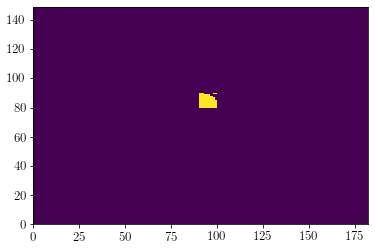

In [36]:
w = xr.open_dataset('/gpfs/home/mep22dku/scratch/LimitsOfPhytoplankton/data//TOM12_TJ_R4A0_y2020_DIA_LoP.nc')

plt.pcolormesh(w.limitNut[0,0,:,:])


## random bordel

In [37]:
import pandas as pd
pars = pd.read_csv('nam-trc-sms-phy.csv', index_col=0)
pars.head()
# # Extract the value at row 'rn_phy' and column 'DIA'
value = pars.loc['rn_resphy', 'DIA']

#print(value)
# pPFT_const = {
#     "DIA": {"rn_kmnphy": 165, "rn_kmpphy": 68, "rn_resphy": 6, "rn_rhfphy": 6,},

# }


# rn_qmaphy
# rn_qmiphy
# rn_kmfphy
# rn_qopphy
# rn_tliphy
# rn_resphy
# rn_alpphy
# rn_thmphy
# rn_docphy

        # print(f'rn_qmaphy: {rn_qmaphy} (maximum quota for Fe)')
        # print(f'rn_qmiphy: {rn_qmiphy} (min quota for Fe)')
        # print(f'rn_rhfphy: {rn_rhfphy} (threshold for nutrient uptake for Fe)')
        # print(f'rn_tliphy: {rn_tliphy} (threshold by phytopl. for light)')
        # print(f'rn_mumpft: {rn_mumpft} (maximum growth rate)')
        # print(f'rn_resphy: {rn_resphy} (phyto respiration as a fraction of growth)')
        # print(f'rn_thmphy: {rn_thmphy} (maximum chl:C ratio rn_thmphy)')
        # print(f'rn_docphy: {rn_docphy} (excretion ratio)')

FileNotFoundError: [Errno 2] No such file or directory: 'nam-trc-sms-phy.csv'

In [ ]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]



## chatgpt translation (not super helpful)

In [ ]:
import numpy as np

ttry = False

if ttry:
    # Example initialization of variables and arrays (replace these with actual data)
    jpk = 10
    nlcj = 10
    nlci = 10
    jpdia = 2
    jppft = 3
    jpfix = 5
    jppo4, jpsil, jpdin, jpfer, jpdoc = 1, 2, 3, 4, 5
    rn_kmpphy = np.random.rand(jpdia + jppft)
    rn_nutthe = 0.1
    rn_sildia = 0.2
    rn_kmnphy = np.random.rand(jpdia + jppft)
    rn_kmpbac = 0.3
    rn_kmfbac = 0.4
    rn_kmobac = 0.5
    rn_munfix = 0.6
    rtrn = 0.1
    pcmax = np.random.rand(jpdia + jppft)
    rn_mumpft = np.random.rand(jpdia + jppft)
    rn_resphy = np.random.rand(jpdia + jppft)
    rn_alpphy = np.random.rand(jpdia + jppft)
    rn_docphy = np.random.rand(jpdia + jppft)
    rn_domphy = np.random.rand(jpdia + jppft)
    rn_qmaphy = np.random.rand(jpdia + jppft)
    rn_qmiphy = np.random.rand(jpdia + jppft)
    rn_qopphy = np.random.rand(jpdia + jppft)
    rn_rhfphy = np.random.rand(jpdia + jppft)
    rn_thmphy = np.random.rand(jpdia + jppft)
    rn_tliphy = np.random.rand(jpdia + jppft)
    tgfunc = np.random.rand(nlci, nlcj, jpk, jpdia + jppft)
    etot = np.random.rand(nlci, nlcj, jpk)
    stofoo = np.random.rand(nlci, nlcj, jpk, jpdia + jppft, 4)
    prophy = np.random.rand(nlci, nlcj, jpk, jpdia + jppft, 4)
    docphy = np.random.rand(nlci, nlcj, jpk, jpdia + jppft)
    prorca3 = np.random.rand(nlci, nlcj, jpk)
    xlimpft = np.random.rand(nlci, nlcj, jpk, jpdia + jppft)
    dinpft = np.random.rand(nlci, nlcj, jpk, jpdia + jppft)
    tmask = np.ones((nlci, nlcj, jpk))
    trn = np.random.rand(nlci, nlcj, jpk, 6)

    # Initialize result arrays
    xlim4 = np.zeros(jpdia + jppft)
    xlim5 = np.ones(jpdia + jppft)
    xlim6 = np.zeros(jpdia + jppft)
    quopfe = np.zeros(jpdia + jppft)
    vcfer = np.zeros(jpdia + jppft)
    rhochl = np.zeros(jpdia + jppft)
    xlim7 = np.zeros(jpdia + jppft)
    perfrm = np.zeros(jpdia + jppft)

    # Main computation loop
    for jk in range(1, jpk):
        for jj in range(1, nlcj - 1):
            for ji in range(1, nlci - 1):

                # Diatoms
                jl = jpdia

                xlim4[jl] = (trn[ji, jj, jk, jppo4] - rn_kmpphy[jl] * rn_nutthe) / \
                            (trn[ji, jj, jk, jppo4] + rn_kmpphy[jl] * (1. - rn_nutthe))

                xlim5[jl] = (trn[ji, jj, jk, jpsil] - rn_sildia * rn_nutthe) / \
                            (trn[ji, jj, jk, jpsil] + rn_sildia * (1. - rn_nutthe))

                xlim6[jl] = (trn[ji, jj, jk, jpdin] - rn_kmnphy[jl] * rn_nutthe) / \
                            (trn[ji, jj, jk, jpdin] + rn_kmnphy[jl] * (1. - rn_nutthe))

                for jl in range(jpdia + 1, jpdia + jppft - 1):

                    xlim4[jl] = (trn[ji, jj, jk, jppo4] - rn_kmpphy[jl] * rn_nutthe) / \
                                (trn[ji, jj, jk, jppo4] + rn_kmpphy[jl] * (1. - rn_nutthe))

                    xlim6[jl] = (trn[ji, jj, jk, jpdin] - rn_kmnphy[jl] * rn_nutthe) / \
                                (trn[ji, jj, jk, jpdin] + rn_kmnphy[jl] * (1. - rn_nutthe))

                # Michaelis-Menten Limitation term for nutrients for bacteria
                xlim1 = trn[ji, jj, jk, jppo4] / (trn[ji, jj, jk, jppo4] + rn_kmpbac)
                xlim2 = trn[ji, jj, jk, jpfer] / (trn[ji, jj, jk, jpfer] + rn_kmfbac)
                xlim3 = trn[ji, jj, jk, jpdoc] / (trn[ji, jj, jk, jpdoc] + rn_kmobac)
                xlimbac = np.minimum(np.minimum(xlim1, xlim2), xlim3)

                # N2 fixers
                jl = jpfix
                xlim4[jl] = (trn[ji, jj, jk, jppo4] - rn_kmpphy[jl] * rn_nutthe) / \
                            (trn[ji, jj, jk, jppo4] + rn_kmpphy[jl] * (1. - rn_nutthe))
                dinlim = (trn[ji, jj, jk, jpdin] - rn_kmnphy[jl] * rn_nutthe) / \
                         (trn[ji, jj, jk, jpdin] + rn_kmnphy[jl] * (1. - rn_nutthe))
                xlim6[jl] = dinlim + rn_munfix * (1. - dinlim)
                dinpft[ji, jj, jk, jl] = dinlim / (xlim6[jl] + rtrn) * tmask[ji, jj, jk]

                for jl in range(jpdia, jpdia + jppft):
                    stofoo[ji, jj, jk, jl, 2] = trn[ji, jj, jk, jl + jppft] / (trn[ji, jj, jk, jl] + rtrn)
                    stofoo[ji, jj, jk, jl, 3] = trn[ji, jj, jk, jl + 2 * jppft] / (trn[ji, jj, jk, jl] + rtrn)
                    quopfe[jl] = np.maximum(np.minimum(stofoo[ji, jj, jk, jl, 2], rn_qmaphy[jl]), rn_qmiphy[jl])
                    xlim1 = (rn_rhfphy[jl] * rn_qmaphy[jl] - rn_qmaphy[jl]) * \
                            (rn_qmaphy[jl] - quopfe[jl]) / (rn_qmaphy[jl] - rn_qmiphy[jl]) + rn_qmaphy[jl]
                    xlim2 = trn[ji, jj, jk, jpfer] / (trn[ji, jj, jk, jpfer] + rn_kmfphy[jl])
                    xlim3 = np.minimum((quopfe[jl] - rn_qmiphy[jl]) / (rn_qopphy[jl] - rn_qmiphy[jl]), 1.) * \
                            (1. + rn_nutthe) - rn_nutthe
                    xlim7[jl] = (4.6 * etot[ji, jj, jk] - rn_tliphy[jl]) * rn_nutthe / \
                                (4.6 * etot[ji, jj, jk] + rn_tliphy[jl] * (1. - rn_nutthe))
                    xlimpft[ji, jj, jk, jl] = np.minimum(np.minimum(xlim4[jl], xlim5[jl]), np.minimum(xlim6[jl], xlim3))

                    # Fe uptake rate

                    vcfer[jl] = rn_mumpft[jl] * (1. + rn_resphy[jl]) * xlim1 * np.minimum(xlim4[jl], np.minimum(xlim5[jl], xlim6[jl])) * xlim2

                    # Light limitation
                    perfrm[jl] = np.maximum(rn_alpphy[jl] * stofoo[ji, jj, jk, jl, 3] * (4.6 * etot[ji, jj, jk] - rn_tliphy[jl]), 0.)
                    pctnut = pcmax[jl] * xlimpft[ji, jj, jk, jl] * tgfunc[ji, jj, jk, jl]
                    xlim8 = (1. - np.exp(-perfrm[jl] / (pctnut + rtrn)))
                    pcphot[jl] = pctnut * xlim8
                    rhochl[jl] = rn_thmphy[jl] * pcphot[jl] / (perfrm[jl] + rtrn)

                    # Synthesis rates
                    prophy[ji, jj, jk, jl, 3] = rhochl[jl] * pcphot[jl] * trn[ji, jj, jk, jl] * rfact
                    prophy[ji, jj, jk, jl, 2] = vcfer[jl] * xlim8 * tgfunc[ji, jj, jk, jl] * trn[ji, jj, jk, jl] * rfact / rjjss
                    prophy[ji, jj, jk, jl, 1] = pcphot[jl] * trn[ji, jj, jk, jl] * rfact
                    docphy[ji, jj, jk, jl] = prophy[ji, jj, jk, jl, 1] * (rn_docphy[jl] + (1. - xlimpft[ji, jj, jk, jl]) * rn_domphy[jl])


In [ ]:
tmesh.gdept_1d[0,0:22]